In [110]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import math


matplotlib.use('Agg')
%matplotlib inline
np.random.seed(11)

In [255]:
df = pd.read_csv('data/bbri_updated.csv', usecols=[0,4]);

In [256]:
df = df.set_index('Date')
df

,Close
Date,
2019-11-14,3940.0
2019-11-15,4090.0
2019-11-18,4120.0
2019-11-19,4190.0
2019-11-20,4220.0
...,...
2020-12-17,4330.0
2020-12-18,4280.0
2020-12-21,4210.0


In [113]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [114]:
dataset = df.values
dataset = dataset.astype('float32')

In [115]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
scaled = scaler.fit_transform(df)
scaled = pd.DataFrame(scaled)

dataset = scaled.values
scaled

,0
0,0.688716
1,0.747082
2,0.758755
3,0.785992
4,0.797665
...,...
266,0.840467
267,0.821012
268,0.793774
269,0.762646


### Split Data Train and Test

In [116]:
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [157]:
look_back = 10
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX.shape

(205, 10)

### Create Model 

In [126]:
def model(type):
    
    if type == 'svm':
        models = SVR(kernel='rbf', C=1e3, gamma=0.1)
    elif type == 'ann':
        models = Sequential()
        models.add(Dense(10, input_dim=look_back, activation='relu', use_bias=True, bias_initializer='ones')) #inisialisasi input layer dan hidden layer
        models.add(Dense(10, activation='relu', use_bias=True, bias_initializer='ones')) #hidden layer 2
        models.add(Dense(1, activation='relu')) #inisialisasi output layer
        models.compile(loss='mean_squared_error', optimizer='adam')
        models.summary()
    elif type == 'lstm':
        models = Sequential()
#         models.add(LSTM(units=4,return_sequences=True, input_shape=(1,10)))
#         models.add(Dropout(0.2))
        
#         models.add(Dense(10, activation='relu', use_bias=True, bias_initializer='ones'))
#         models.add(LSTM(units=4))
#         models.add(Dropout(0.2))
        
#         models.add(Dense(1))
#         models.compile(loss='mean_squared_error', optimizer='nadam')

        models.add(LSTM(4, input_shape=(1, look_back)))
        models.add(Dense(1))
        models.compile(loss='mean_squared_error', optimizer='adam')
        
        models.summary()
    return models

### Plot Forecast Function

In [127]:
def plot_forecast(dataset,look_back, train, test, model, plotName):
    
    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(train)+look_back, :] = train
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(train)+(look_back*2)+1:len(dataset)-1, :] = test
    
    # Show Plot
    plt.title(plotName)
    plt.plot(scaler.inverse_transform(dataset))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.savefig('output/beta/{}_graph.png'.format(model))
    plt.show()

In [287]:
def plot_forecast_cut(dataset,look_back, train, test, model, plotName):
    
    testPredictPlot = np.zeros(shape=(len(test)+1,1))
    testPredictPlot = test[len(test)-look_back:len(test)]
    
    dateIndex = df.index[len(df['Close'])-look_back: len(df['Close'])].to_list()

    # Show Plot
    plt.figure(figsize=(15,5))
    plt.title(plotName)
    plt.plot(dateIndex,df['Close'][len(df['Close'])-look_back: len(df['Close'])].values, label='Hasil Sebenarnya')
    plt.plot(testPredictPlot, label='Hasil Prediksi')
    plt.legend()
    plt.savefig('output/beta/{}_tren_graph.png'.format(model))
    plt.show()

### ANN Model

In [128]:
ann = model('ann')

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_26 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 11        
Total params: 231
Trainable params: 231
Non-trainable params: 0
_________________________________________________________________


In [129]:
# trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
# testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [130]:
history_ann = ann.fit(trainX,trainY, epochs=100,
#                       batch_size=32,
                      validation_data=(testX,testY),
                      verbose=2, callbacks=[EarlyStopping(monitor='val_loss', patience=10)], shuffle=False)

Epoch 1/100
7/7 - 0s - loss: 3.0201 - val_loss: 1.8413
Epoch 2/100
7/7 - 0s - loss: 1.7446 - val_loss: 0.9052
Epoch 3/100
7/7 - 0s - loss: 0.8842 - val_loss: 0.3567
Epoch 4/100
7/7 - 0s - loss: 0.3714 - val_loss: 0.0942
Epoch 5/100
7/7 - 0s - loss: 0.1193 - val_loss: 0.0110
Epoch 6/100
7/7 - 0s - loss: 0.0274 - val_loss: 0.0148
Epoch 7/100
7/7 - 0s - loss: 0.0116 - val_loss: 0.0384
Epoch 8/100
7/7 - 0s - loss: 0.0166 - val_loss: 0.0501
Epoch 9/100
7/7 - 0s - loss: 0.0190 - val_loss: 0.0467
Epoch 10/100
7/7 - 0s - loss: 0.0164 - val_loss: 0.0366
Epoch 11/100
7/7 - 0s - loss: 0.0130 - val_loss: 0.0271
Epoch 12/100
7/7 - 0s - loss: 0.0111 - val_loss: 0.0210
Epoch 13/100
7/7 - 0s - loss: 0.0106 - val_loss: 0.0180
Epoch 14/100
7/7 - 0s - loss: 0.0105 - val_loss: 0.0171
Epoch 15/100
7/7 - 0s - loss: 0.0104 - val_loss: 0.0174


### RMSE ANN

In [131]:
trainScoreAnn = ann.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.3f MSE (%.3f RMSE) ANN' % (trainScoreAnn, math.sqrt(trainScoreAnn)))

testScoreAnn = ann.evaluate(testX, testY, verbose=0)
print('Test Score: %.3f MSE (%.3f RMSE) ANN' % (testScoreAnn, math.sqrt(testScoreAnn)))

Train Score: 0.010 MSE (0.101 RMSE) ANN
Test Score: 0.017 MSE (0.132 RMSE) ANN


### Plot Loss ANN

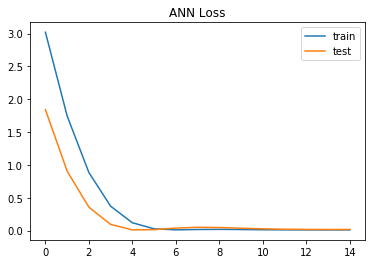

In [132]:
plt.title('ANN Loss')
plt.plot(history_ann.history['loss'],label='train')
plt.plot(history_ann.history['val_loss'],label='test')
plt.legend()
plt.savefig('output/beta/ann_loss.png')

plt.show()

In [133]:
trainPredictAnn = ann.predict(trainX)
testPredictAnn = ann.predict(testX)

trainPredictTempAnn = np.zeros(shape=(len(trainPredictAnn), 1))
trainPredictTempAnn[:,0] = trainPredictAnn[:,0]

trainPredictAnn = scaler.inverse_transform(trainPredictTempAnn)[:,0]


testPredictTempAnn = np.zeros(shape=(len(testPredictAnn), 2))
testPredictTempAnn[:,0] = testPredictAnn[:,0]
testPredictAnn = scaler.inverse_transform(testPredictTempAnn)[:,0]

### Plot Forecast ANN

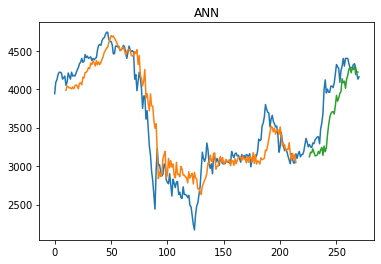

In [134]:
plot_forecast(dataset,look_back,trainPredictAnn.reshape(-1,1),testPredictAnn.reshape(-1,1),'ann','ANN')

### Plot Tren ANN

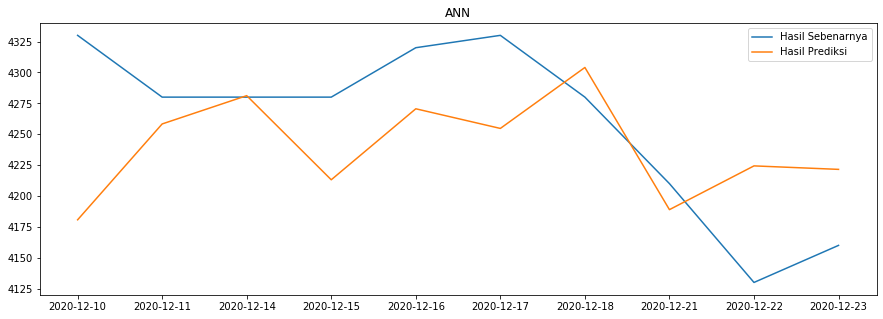

In [290]:
plot_forecast_cut(dataset,look_back,trainPredictAnn.reshape(-1,1),testPredictAnn.reshape(-1,1),'ann','ANN')

### LSTM Model

In [135]:
lstm = model('lstm')

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 240       
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 5         
Total params: 245
Trainable params: 245
Non-trainable params: 0
_________________________________________________________________


In [136]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
trainX.shape,testX.shape

((205, 1, 10), (44, 1, 10))

In [137]:
history_lstm = lstm.fit(trainX,trainY,epochs=100,
#                       batch_size=1,
                      validation_data=(testX,testY),
                      verbose=1, callbacks=[EarlyStopping(monitor='val_loss', patience=10)], shuffle=False)

Epoch 1/100
7/7 [==============================] - 0s 35ms/step - loss: 0.3594 - val_loss: 0.5132
Epoch 2/100
7/7 [==============================] - 0s 5ms/step - loss: 0.3477 - val_loss: 0.4981
Epoch 3/100
7/7 [==============================] - 0s 5ms/step - loss: 0.3367 - val_loss: 0.4833
Epoch 4/100
7/7 [==============================] - 0s 6ms/step - loss: 0.3258 - val_loss: 0.4687
Epoch 5/100
7/7 [==============================] - 0s 5ms/step - loss: 0.3151 - val_loss: 0.4541
Epoch 6/100
7/7 [==============================] - 0s 5ms/step - loss: 0.3044 - val_loss: 0.4395
Epoch 7/100
7/7 [==============================] - 0s 5ms/step - loss: 0.2937 - val_loss: 0.4248
Epoch 8/100
7/7 [==============================] - 0s 5ms/step - loss: 0.2830 - val_loss: 0.4099
Epoch 9/100
7/7 [==============================] - 0s 5ms/step - loss: 0.2722 - val_loss: 0.3948
Epoch 10/100
7/7 [==============================] - 0s 5ms/step - loss: 0.2613 - val_loss: 0.3796
Epoch 11/100
7/7 [==========

7/7 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0090
Epoch 85/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0106 - val_loss: 0.0089
Epoch 86/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0104 - val_loss: 0.0088
Epoch 87/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0102 - val_loss: 0.0087
Epoch 88/100
7/7 [==============================] - 0s 6ms/step - loss: 0.0101 - val_loss: 0.0086
Epoch 89/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0099 - val_loss: 0.0085
Epoch 90/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0098 - val_loss: 0.0084
Epoch 91/100
7/7 [==============================] - 0s 6ms/step - loss: 0.0097 - val_loss: 0.0083
Epoch 92/100
7/7 [==============================] - 0s 6ms/step - loss: 0.0095 - val_loss: 0.0082
Epoch 93/100
7/7 [==============================] - 0s 5ms/step - loss: 0.0094 - val_loss: 0.0081
Epoch 94/100
7/7 [===============

### RMSE LSTM

In [138]:
trainScoreLstm = lstm.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.3f MSE (%.3f RMSE) LSTM' % (trainScoreLstm, math.sqrt(trainScoreLstm)))

testScoreLstm = lstm.evaluate(testX, testY, verbose=0)
print('Test Score: %.3f MSE (%.3f RMSE) LSTM' % (testScoreLstm, math.sqrt(testScoreLstm)))

trainScoreLstm = trainScoreLstm
testScoreLstm = testScoreLstm
rmseTrain = math.sqrt(trainScoreLstm)
rmseTest = math.sqrt(testScoreLstm)
score = np.array([trainScoreLstm,testScoreLstm,rmseTrain,rmseTest])
np.savetxt("output/beta/score_lstm.txt",score, delimiter=";")

Train Score: 0.008 MSE (0.092 RMSE) LSTM
Test Score: 0.008 MSE (0.087 RMSE) LSTM


### Plot Loss LSTM

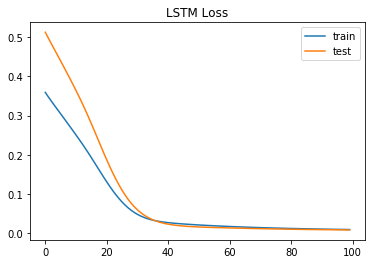

In [139]:
plt.title('LSTM Loss')
plt.plot(history_lstm.history['loss'],label='train')
plt.plot(history_lstm.history['val_loss'],label='test')
plt.legend()
plt.savefig('output/beta/lstm_loss.png')
plt.show()

In [140]:
trainPredictLstm = lstm.predict(trainX)
testPredictLstm = lstm.predict(testX)

trainPredictTempLstm = np.zeros(shape=(len(trainPredictLstm), 2))
trainPredictTempLstm[:,0] = trainPredictLstm[:,0]
trainPredictLstm = scaler.inverse_transform(trainPredictTempLstm)[:,0]


testPredictTempLstm = np.zeros(shape=(len(testPredictLstm), 2))
testPredictTempLstm[:,0] = testPredictLstm[:,0]
testPredictLstm = scaler.inverse_transform(testPredictTempLstm)[:,0]

### Plot Forecast LSTM

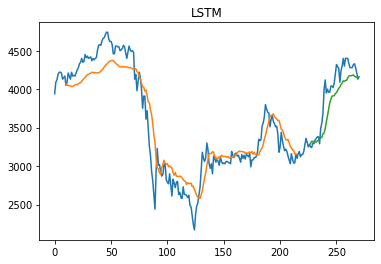

In [141]:
plot_forecast(dataset,look_back,trainPredictLstm.reshape(-1,1),testPredictLstm.reshape(-1,1),'lstm','LSTM')

### Plot Tren LSTM

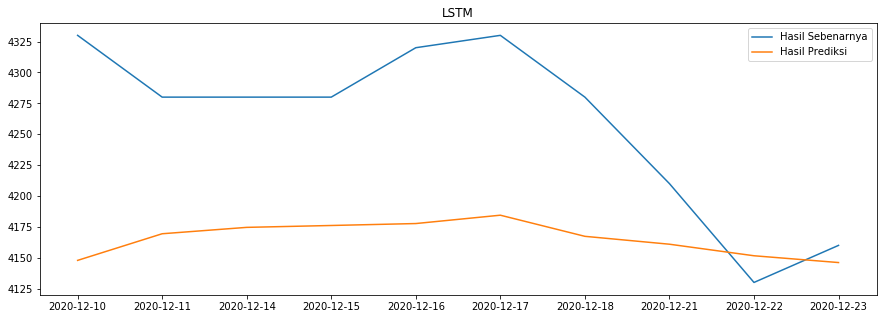

In [289]:
plot_forecast_cut(dataset,look_back,trainPredictLstm.reshape(-1,1),testPredictLstm.reshape(-1,1),'lstm','LSTM')

### SVM Model

In [151]:
svm = model('svm')

In [159]:
trainX = np.reshape(trainX,(trainX.shape[0], trainX.shape[1]))

In [160]:
svm.fit(trainX,trainY)

SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

### SVM Score

In [161]:
svm_confidence = svm.score(testX, testY)
print("svm confidence: ", svm_confidence)

svm confidence:  0.8619504771003695


In [162]:
y_pred_svm = svm.predict(testX)

y_pred_svm = np.reshape(y_pred_svm,(len(y_pred_svm),1))

yPredTemp = np.zeros(shape=(len(y_pred_svm), 2))
yPredTemp[:,0] = y_pred_svm[:,0]
y_pred_svm_decode = scaler.inverse_transform(yPredTemp)[:,0]


trainPredictSvm = svm.predict(trainX)
trainPredictSvm = np.reshape(trainPredictSvm,(len(trainPredictSvm),1))

trainPredTempSvm = np.zeros(shape=(len(trainPredictSvm), 2))
trainPredTempSvm[:,0] = trainPredictSvm[:,0]
trainPredictSvm_decode = scaler.inverse_transform(trainPredTempSvm)[:,0]

### RMSE SVM

In [163]:
mse_svm = mean_squared_error(testY, y_pred_svm)
rmse_svm = np.sqrt(mse_svm)

print('Test Score: %.3f MSE (%.3f RMSE) SVM' % (mse_svm, rmse_svm))

Test Score: 0.003 MSE (0.058 RMSE) SVM


### Plot Forecast SVM

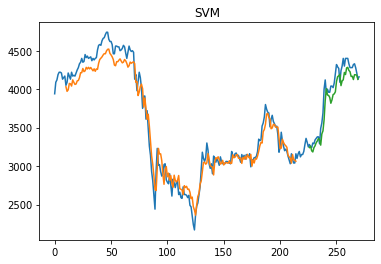

In [164]:
plot_forecast(dataset, look_back, trainPredictSvm_decode.reshape(-1,1),y_pred_svm_decode.reshape(-1,1),'svm','SVM')

### Plot tren SVM

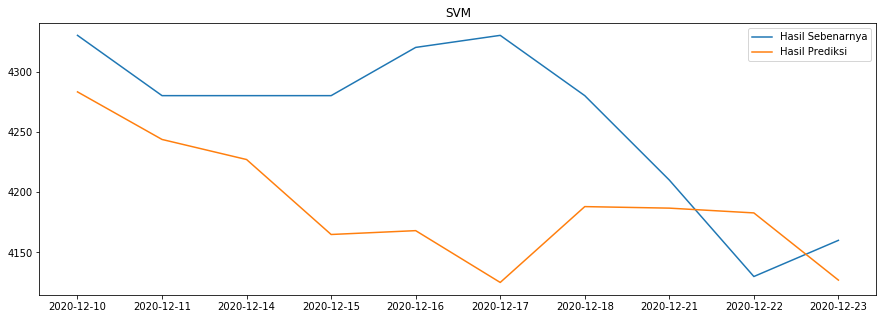

In [288]:
plot_forecast_cut(dataset,look_back,trainPredictSvm_decode.reshape(-1,1),y_pred_svm_decode.reshape(-1,1),'svm','SVM')